# Notebook for the development of functions

In [2]:
%matplotlib inline
import sys
import os
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('../'))

# Dark matter subhalo impact parameter sampling

## Subhalo density

From model, compute estimation of the subhalo density to compute the impact rate

In [3]:
import numpy as np
from scipy.integrate import quad
import astropy.units as u
from astropy.units import Quantity


class DMS_Distribution:
    """
    A class to model the distribution of dark matter subhalos (DMS)
    in a galactic halo. Includes:
     - Number of subhalos within a mass range and galactic radius;
     - Subhalo intrinsic spatial profile;
     - Mass and radius configuration.
    """

    def __init__(self,
                 profile='einasto',
                 profile_params=None,
                 r_max=300.0):
        self.profile = profile
        self.profile_params = profile_params or {'alpha': 0.678, 'r_minus2': 199}
        self.r_max = r_max

    def _to_quantity(self, val, unit):
        """
        Convert float or int to Quantity with assumed unit,
        or return the Quantity with correct unit.
        """
        if isinstance(val, Quantity):
            return val.to(unit)
        else:
            return val * unit

    def mass_function(self, M, a0=3.26e-5, m0=2.52e7, n=-1.9):
        """
        Subhalo mass function dN/dM (cf: The Aquarius Project: the subhalos of galactic halosV. Springel1, J. Wang).
        """
        return a0 * (M / m0)**n

    def integrate_mass_function(self, M_min, M_max):
        """
        Integrate the subhalo mass function over a given mass range.
        """
        return quad(lambda M: self.mass_function(M), M_min, M_max)[0]

    def spatial_profile(self, r):
        """
        Spatial number density profile of subhalos.
        Currently supports only 'einasto'.
        """
        if self.profile == 'einasto':
            alpha = self.profile_params['alpha']
            r_minus2 = self.profile_params['r_minus2']
            x = r / r_minus2
            return np.exp(-2 / alpha * (x**alpha - 1))
        else:
            raise NotImplementedError(f"Profile {self.profile} not implemented. Profiles: ['einasto']")

    def integrate_spatial_profile(self, r_min=0.01, r_max=500):
        """
        Fraction of subhalos within [r_min, r_max] based on spatial profile.
        """
        r_max = r_max or self.r_max

        integrand = lambda r: 4 * np.pi * r**2 * self.spatial_profile(r)

        total = quad(integrand, 0.01, self.r_max)[0]
        partial = quad(integrand, r_min, r_max)[0]

        return partial / total

    def number_involume_inmassrange(self, R, M_min=1e5, M_max=1e9):
        """
        Total number of subhalos within radius R.
        """
        R = self._to_quantity(R, u.kpc).value
        M_min = self._to_quantity(M_min, u.Msun).value
        M_max = self._to_quantity(M_max, u.Msun).value

        N_mass = self.integrate_mass_function(M_min, M_max)
        N_radius = self.integrate_spatial_profile(r_max=R)
        return N_mass * N_radius

    def density_involume_inmassrange(self, R, M_min=1e5, M_max=1e9):
        """
        density (/kpc3) of subhalos within radius R.
        """
        R = self._to_quantity(R, u.kpc)
        V = (4/3) * np.pi * R**3

        N = self.number_involume_inmassrange(R, M_min, M_max)
        return (N / V).to(1 / u.kpc**3)

    def bmax_inmassrange(self, M_min, M_max, profile='NFW', alpha=5.0):
        """
        Typical bmax in the considered mass range. Depends of the subhalo profile and an adjustable parameter
        """
        M_min = self._to_quantity(M_min, u.Msun).value
        M_max = self._to_quantity(M_max, u.Msun).value
        M_avg = 10**np.mean([np.log10(M_min), np.log10(M_max)])

        if profile == 'NFW':
            c = 15 * (M_avg / 1e8)**-0.1 #concentration profile
            r_vir = 1.0 * (M_avg / 1e8)**(1/3)  # virial radius
            rs = r_vir / c
        elif profile == 'Plummer':
            rs = (M_avg / 1e8)**0.5 * 1.0
        else:
            raise ValueError("Unrecognized profile. choose NFW or Plummer")

        return (alpha * rs) * u.kpc



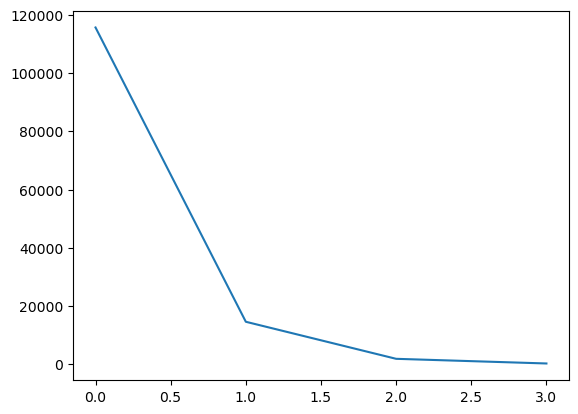

In [4]:
###Tests on mass/spatial distribution functions

# alpha, r_minus2 = 0.678, 199
# x = np.linspace(0.01,25,1000)/r_minus2
# plt.figure()
# plt.loglog(x,np.exp(-2 / alpha * (x**alpha - 1)))
# plt.show()



def mass_function(m, a0=3.26e-5, m0=2.52e7, n=-1.9):
    """
    Subhalo mass function dN/dM (cf: The Aquarius Project: the subhalos of galactic halosV. Springel1, J. Wang).
    """
    return a0 * (m / m0)**n

mass_bins = [1e5, 1e6, 1e7, 1e8, 1e9]
mass_df = []
for i in range(len(mass_bins)-1):
    M_min, M_max = mass_bins[i], mass_bins[i+1]
    integrated_massprofile = quad(lambda m: mass_function(m), M_min, M_max)[0]
    mass_df.append(integrated_massprofile)

plt.figure()
plt.plot(mass_df)
plt.show()



## impact rate

from physical parameters, compute the average number of encounter with subhalos the stream had during its past lifetime.

In [5]:
def expected_N_encounters(r_avg, sigma_h, t_d, delta_omega, b_max, n_h):
    '''
    From unperturbed stream data and DMS properties, compute the expected number of encounters between sts and DMS
    Parameters:
     - r_avg: average galactocentric radius of the stream (kpc)
     - sigma_h: velocity dispersion (km/s)
     - t_d: stream age (Gyr)
     - delta_omega: mean-paralel-frequency parameter of the smooth stream (rad/Gyr)
     - b_max: max impact parameter (kpc)
     - n_h: sub_halo density (kpc^-3)

    '''
    #convert to correct quantity
    def _to_quantity(val, unit):
        if isinstance(val, Quantity):
            return val.to(unit)
        else:
            return val * unit

    r_avg = _to_quantity(r_avg, u.kpc)
    sigma_h = _to_quantity(sigma_h, u.km/u.s).to(u.kpc/u.Gyr)
    t_d = _to_quantity(t_d, u.Gyr)
    delta_omega =_to_quantity(delta_omega, u.rad/u.Gyr)
    b_max = _to_quantity(b_max, u.kpc)
    n_h = _to_quantity(n_h, 1/u.kpc**(3))
    
    N_enc = (np.sqrt(np.pi) / 2) * r_avg * sigma_h * t_d**2 \
            * delta_omega * b_max * n_h
    
    return N_enc

## Unperturbed stream sampling


In [6]:
import numpy as np
import galpy.potential as gp
import galpy.actionAngle as ga
from galpy.orbit import Orbit
from galpy.df import streamdf
import stream_galsim.stream_utils as sutils

class NonPerturbedStreamModel:
    '''
    Generate a unperturbed stream model and retrieve data to generate impact parameters distribution
    '''
    def __init__(self, sigv, progenitor, pot, aA, tdisrupt, leading=True, ro=8.122, vsun=[-12.9, 245.6, 7.78]):
        self.t_disrupt = t_disrupt.to_value('Gyr')
        self.orbit = progenitor
        self.pot = pot
        # Generate stream
        self.stream = streamdf(sigv = sigv,
            progenitor=progenitor,
            pot=pot,
            aA=aA,
            tdisrupt=tdisrupt,
            leading=leading,
            ro = ro,
            vsun=vsun,
            nTrackChunks=26,
            )
    
    def stream_length(self):
        return self.stream.length(threshold=0.1)
    
    def streamdf(self):
        return self.stream

    def compute_r_avg_max(self, npts=1000):
        #average and maximum radii from the galactic center of the orbit 
        ts = np.linspace(0., -self.t_disrupt, npts)
        self.orbit.integrate(ts, self.pot)
        r = np.sqrt(self.orbit.x(ts)**2 + self.orbit.y(ts)**2 + self.orbit.z(ts)**2)
        return np.mean(r), np.max(r)

    def compute_Omega_parallel(self, npts=1000):
        # Sample angles and frequencies
        aA_data = self.stream.sample(n=npts, returnaAdt=True)  # list of (actions, angles, freqs)
        freqs = aA_data[0].T
        angles = aA_data[1].T

        # Find dominant direction in angle-space
        angles_centered = angles - angles.mean(axis=0)
        _, _, Vt = np.linalg.svd(angles_centered)
        diff_dir = Vt[0]  # principal component

        # Project average frequency onto that direction
        Omega_mean = freqs.mean(axis=0)
        Omega_parallel = np.dot(Omega_mean, diff_dir)
        return abs(Omega_parallel)

    def get_disruption_time(self):
        return self.t_disrupt


In [7]:
import astropy.coordinates as ac
with ac.galactocentric_frame_defaults.set("v4.0"):
    galcen_frame = ac.Galactocentric()
###test 
###Progenitor
#progenitor coord 
prog_orbit = Orbit([229.0, -0.124, 22.9, -2.296, -2.257, -58.7], radec=True)

prog_mass = 2*10.**4.*u.Msun
prog_a = 4.*u.pc #scale radius of the plummer sphere
rc = 23*u.pc #progenitor radius
prog_pot = gp.PlummerPotential(prog_mass, prog_a)#Define progenitor with a plummer potential
prog_sigv = sutils.Plummer_sigv(prog_mass, prog_a, rc)/2.15 #velocity dispersion in original cluster.
#It's assumed that the velocity distribution is isotropic
print(prog_sigv)
t_disrupt = 4.5*u.Gyr #time of disruption of cluster, typically 4.5Gyr
# tdisrupt= guc.time_in_Gyr(V0,R0)

###Accreting host
### Usually Milky way potential
V0, R0= 245.6, 8.122 #scale parameters
vsun=[-12.9,245.6,7.78] #for streamdf, vxyz
mw_pot = gp.MWPotential2014
#mw_pot = gp.LogarithmicHaloPotential(normalize=1.,q=0.9) #is also often used

aaisochrone = ga.actionAngleIsochroneApprox(pot=mw_pot,b=1.5)

0.36448724205723426 km / s


In [8]:
###tests
stream_model = NonPerturbedStreamModel(sigv = prog_sigv,
            progenitor=prog_orbit,
            pot=mw_pot,
            aA=aaisochrone,
            leading=True,
            ro = R0, #Distance scale for translation into internal units
            vsun=vsun,
            tdisrupt=t_disrupt)
# print(self.t_disrupt,self.pot,self.orbit,self.sigv,self.aA,self.leading,self.ro,self.vsun)

In [9]:
# stream_model.streamdf().plotTrack(d1='x',d2='y',interp=True,color='k',spread=2,overplot=False,lw=2.,scaleToPhysical=True)
stream_model.stream_length()

1.6935866245803382

[0.73097003 0.51914007 0.53388848]


(array([  5.,  17.,  62., 158., 243., 253., 163.,  69.,  28.,   2.]),
 array([0.        , 0.00061012, 0.00122023, 0.00183035, 0.00244046,
        0.00305058, 0.00366069, 0.00427081, 0.00488092, 0.00549104,
        0.00610115]),
 <BarContainer object of 10 artists>)

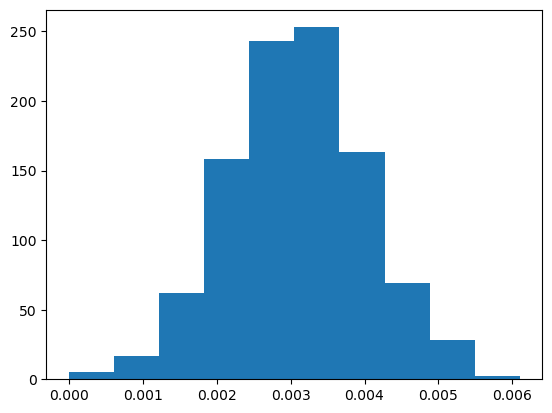

In [9]:
def compute_Omega_parallel(npts=1000):
    # Sample angles and frequencies
    aA_data = stream_model.streamdf().sample(n=npts, returnaAdt=True)  # list of (actions, angles, freqs)
    freqs = aA_data[0].T
    angles = aA_data[1].T

    # Find dominant direction in angle-space
    angles_centered = angles - angles.mean(axis=0)
    _, _, Vt = np.linalg.svd(angles_centered)
    diff_dir = Vt[0]  # principal component
    # print(diff_dir/np.linalg.norm(diff_dir))

    # Project average frequency onto that direction
    Omega_mean = freqs - freqs.min(axis=0)
    print(freqs.min(axis=0))
    Omega_parallel = np.dot(Omega_mean, diff_dir)
    return abs(Omega_parallel), Omega_mean

Omega_parallel, freqs = compute_Omega_parallel()
Omega_parallel, freqs
plt.hist(freqs.T[2])
# stream_model.unperturbed_streamdf().plotCompareTrackAAModel()

In [10]:
### Tests on Nenc
Mmin, Mmax = 1e5, 1e9
dms = DMS_Distribution()
bmax = dms.bmax_inmassrange(Mmin, Mmax, profile='NFW', alpha=5)
print(f"{bmax:.2f}")

r_avg, r_max = stream_model.compute_r_avg_max()
d_omega_par = stream_model.compute_Omega_parallel()
td = stream_model.get_disruption_time()
print(r_avg, r_max, d_omega_par,td)

n_h = dms.density_involume_inmassrange(r_max, Mmin, Mmax)
N_h = dms.number_involume_inmassrange(r_max, Mmin, Mmax)
V=(4/3)*np.pi*(r_max*u.kpc)**3
print(f"{n_h}", f"{N_h:.1f}")

expected_N_encounters(r_avg, 150, td, d_omega_par, bmax, n_h)

0.12 kpc
15.879295627829713 18.769286680719258 1.0491782189223435 4.5
0.013922867542613022 1 / kpc3 385.6


<Quantity 78.48185376 rad>

## Impacter properties sampling

Now that we have constructed a model of the distribution of DMS within the Milky Way, we can sample the impact properties of these subhalos with the considered stellar stream. First we start from the estimate N_encounter. This class sum up the impact functions.

Already having the progenitor and an accreting host, we miss an accurate distribution of DMS in the accreting host. Thus we list the impact properties:
- the impact time ti.
- the stream parallel angle at which the impact occurs at the time of closest approach.
- the fly-by velocity of the dark matter halo.
- the impact parameter
- the intrinsic properties of the subhalo (mass, density profile and radius)


In [28]:
import numpy as np
from astropy.units import Quantity
import astropy.units as u

class ImpactSampler:
    '''
    Sample impact properties of a DMS distribution with a STS, from:
     - N_enc: number of impacts the STS has undergone
     - sigma_h: velocity dispersion of the subhalos in km/s
     - smooth_stream: unperturbed stream PDF
     - mass_range: DMS mass range
    
    With functions related to:
     - impact time: t
     - stream parallel angle at which the impact occurs at the time of closest approach: theta
     - intrinsic properties of the subhalo (mass, density profile and radius): mi
     - impact parameter: b
     - fly-by velocity of the dark matter halo: w
    
    Returns sampled DMS with impact properties {(ti, thetai, mi, bi, wi)}
    '''
    def __init__(self, N_enc, mass_range, sigma_h, t_disrupt, stream_length):
        self.stream_length = self._to_quantity(stream_length, u.rad).value
        self.mass_range = self._to_quantity(mass_range, u.Msun).value
        self.sigma_h = self._to_quantity(sigma_h,u.km/u.s).value
        self.t_disrupt = self._to_quantity(t_disrupt, u.Gyr).value
        self.N_enc = np.random.poisson(self._to_quantity(N_enc, u.rad).value)

    def _to_quantity(self, val, unit):
        """
        Convert float or int to Quantity with assumed unit,
        or return the Quantity with correct unit.
        """
        if isinstance(val, Quantity):
            return val.to(unit)
        else:
            return val * unit

    def impact_time(self):
        '''
        Sample impact times t between [t_disrupt, today]. Constuct a probability law that increases linearly with time (stream length) as d_omega*t.
         - N_enc: number of encounters, (int,float)
         - t_disrupt: float.
        '''
        time_function = lambda x: x
        times = []
        t_vals = np.linspace(0, self.t_disrupt, 1000)
        f_vals = time_function(t_vals)
        f_max = f_vals.max()

        while len(times) < int(self.N_enc):
            t = np.random.uniform(0, np.max(t_vals))
            u_ = np.random.uniform(0, f_max)
            if u_ < time_function(t):
                times.append(t)

        return np.array(times)

    def impact_angle(self, impact_times):
        '''
        Sample impact angles theta at corresponding ti.
         - smooth_stream: stream model from galpy.
         - impact_times: float or list.
        '''
        ti_length = self.stream_length * np.array(impact_times) / self.t_disrupt
        impact_angles = np.random.uniform(low=0.05, high=ti_length)
        return impact_angles
    
    def subhalo_masses(self, distribution_profile='Einasto', a0=1.56e-5, m0=2.52e7, n=-1.9):
        '''
        Sample halo masses m in mass range.
         - mass_range: tuple (Mmin, Max)
         - distribution_profile: string (profile)
         - a0,m0,n = floats (distribution parameters)
        '''
        if distribution_profile == 'Einasto':
            mass_function = lambda M: a0 * (M / m0)**n
        else:
            raise NotImplementedError(f"Profile {distribution_profile} not implemented.")

        M_min, M_max = self.mass_range
        masses = []
        M_vals = np.logspace(np.log10(M_min), np.log10(M_max), 1000)
        f_vals = mass_function(M_vals)
        f_max = f_vals.max()

        while len(masses) < self.N_enc:
            M = np.random.uniform(M_min, M_max)
            u_ = np.random.uniform(0, f_max)
            if u_ < mass_function(M):
                masses.append(M)

        return np.array(masses)

    def impact_parameter(self, masses, alpha = 5):
        '''
        Sample impact parameter b from mass distribution. Use the direct relation between the scale radius rs and Mhalo,
        and the relation between rs and b.
        Parameters:
         - mass: of the considered subhalo, float or list, in Msun
         - alpha: factor of the b range to consider b ∈ [-Xrs,Xrs]
        '''
        masses = self._to_quantity(masses, u.Msun)
        rs = 1.05 * u.kpc * (masses / (1e8 * u.Msun))**0.5
        return alpha * rs

    def flyby_velocity(self):
        '''
        From velocity dispersion in the accreting host,
        sample velocity components of the subhalo in the stream fream, because we don't want positive radial velocity.
        return {(w_r, w_phi, w_z)}
        ''' 
        w_r,w_phi,w_z = [],[],[]
        i=0
        while i <int(self.N_enc):
            i+=1
            w_r.append(np.random.rayleigh(scale=self.sigma_h))
            w_phi.append(np.random.normal(scale=self.sigma_h))
            w_z.append(np.random.normal(scale=self.sigma_h))
        return np.array([w_r, w_phi, w_z])

    def impact_list(self):
        t = self.impact_time()
        theta = self.impact_angle(t)
        m = self.subhalo_masses()
        b = self.impact_parameter(m)
        w = self.flyby_velocity()

        return np.array([t,theta,m,b, w[0], w[1], w[2]]).T


In [30]:
t_disrupt = 4.5*u.Gyr 
sigma_h = 150*u.km/u.s
N_enc = expected_N_encounters(r_avg, 150, td, d_omega_par, bmax, n_h)
mass_range = (1e5*u.Msun, 1e9*u.Msun)
stream_length = stream_model.stream_length()

ImpactSample = ImpactSampler(N_enc, mass_range, sigma_h, t_disrupt, stream_length)
ImpactSample.impact_list()
print(len(ImpactSample.impact_list()))

81


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def mass_function(M, a0=1.56e-5, m0=2.52e7, n=-1.9):
    return a0 * (M / m0)**n

def sample_mass(N_samples, M_min=1e6, M_max=1e10):
    samples = []
    M_vals = np.logspace(np.log10(M_min), np.log10(M_max), 1000)
    f_vals = mass_function(M_vals)
    f_max = f_vals.max()

    while len(samples) < N_samples:
        M = np.random.uniform(M_min, M_max)
        u = np.random.uniform(0, f_max)
        if u < mass_function(M):
            samples.append(M)

    return np.array(samples)





In [ ]:
samples = sample_mass(100, M_min=1e5, M_max=1e9)
logbins = np.logspace(np.log10(1e5),np.log10(1e9),5)
plt.hist(samples, bins=logbins,  log=True)
plt.xscale('log')
plt.xlabel("Masse")
plt.ylabel("Nombre")
plt.show()